In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [2]:
# load data 

# House election Harvard Dataverse https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2
district_results = pd.read_csv('1976-2018-house.csv', header=0,encoding = 'unicode_escape')
district_results['candidatevotes'] = district_results['candidatevotes'].str.replace(',', '')
district_results['candidatevotes'] = district_results['candidatevotes'].astype(int)

# 2016 Election Results https://transition.fec.gov/general/FederalElections2016.shtml
pres_gen_results_2016 = pd.read_csv('2016 Pres General Results-Table 1.csv', header=0,encoding = 'unicode_escape')
sen_results_2016 = pd.read_csv('2016 US Senate Results by State-Table 1.csv', header=0,encoding = 'unicode_escape')
house_results_2016 = pd.read_csv('2016 US House Results by State-Table 1.csv', header=0,encoding = 'unicode_escape')

Election_2018 = district_results.loc[district_results['year'] == 2018]

sports_results = pd.read_csv('sports_data.csv')

states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE','DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

In [3]:
import glob

# get data file names
path =r'C:\DRO\DCL_rawdata_files'
filenames = glob.glob('District Data' + "/*.csv")


dfs = {}

filenames.sort()
i = 0 
for filename in filenames:
    dfs['state' + str(i)] = pd.read_csv(filename)
    i = i + 1
    

In [4]:
district_winners_2016 = pd.DataFrame()
for state in states : 
    temp = Election_2018.loc[Election_2018['state_po'] == state]
    #number of districts
    districts_number = temp['district'].max()
    while districts_number > 0 : 
        district = temp.loc[temp['district'] == districts_number]
        winner = pd.DataFrame(district.loc[district['candidatevotes'] == district['candidatevotes'].max()])
        district_winners_2016 = district_winners_2016.append(winner)
        districts_number = districts_number - 1

In [5]:
#will now correctly classify the winning party but doesn't put it into the original dataframe
    
for district in district_winners_2016.iterrows():
    # May be able to use the vote count to assign the correct value back to the original dataframe, 
    # only two winners shared an exact vote count so only 1 collision must be handled
    if district[1]['party'] == 'republican' : 
        district_winners_2016.loc[district[0],'class'] = 0
    elif district[1]['party'] == 'democrat' :
        district_winners_2016.loc[district[0],'class'] = 1
    else:
        district_winners_2016.loc[district[0],'class'] = 2

In [6]:

percentage_below_poverty_line = []
percent_bachelor = []
percent_hs = []
for state in dfs:
    num_cols = len(dfs[state].columns)
    stats_pl = dfs[state][dfs[state]['Subject'] == 'Percentage of Families and People Whose Income in the Past 12 Months is Below the Poverty Level'].iloc[0:1,]
    stats_ba = dfs[state][dfs[state]['Title'] == "Percent bachelor's degree or higher"]
    stats_hs = dfs[state][dfs[state]['Title'] == "Percent high school graduate or higher"]
    pl_mean_sum = 0
    hs_mean_sum = 0
    ba_mean_sum = 0
    for col in range(num_cols):
        if col < 3:
            continue
        elif (col % 2) != 0:
            pl_mean_sum += float(stats_pl.iloc[:,col].values[0])
            hs_mean_sum += float(stats_hs.iloc[:,col].values[0])
            ba_mean_sum += float(stats_ba.iloc[:,col].values[0])
        else:
            continue
            
    pl_mean = pl_mean_sum / ((num_cols - 3)/2)
    percentage_below_poverty_line.append(pl_mean)
    
    hs_mean = hs_mean_sum / ((num_cols - 3)/2)
    
    ba_mean = ba_mean_sum / ((num_cols - 3)/2)
    
    percent_hs.append(hs_mean)
    percent_bachelor.append(ba_mean)
    
    

In [7]:
sports_results['poverty'] = pd.Series(percentage_below_poverty_line)
sports_results['bachelors'] = pd.Series(percent_bachelor)
sports_results['hs'] = pd.Series(percent_hs)

In [8]:
#### LUKE
#Real GDP per capita by state by year
rGDP_pc_2015 = pd.read_csv('Real_GDP_pc/2015_rGDP_edit.csv')
rGDP_pc_2016 = pd.read_csv('Real_GDP_pc/2016_rGDP_edit.csv')
rGDP_pc_2017 = pd.read_csv('Real_GDP_pc/2017_rGDP_edit.csv')
#Unemployment delta by state, 2016--2018
## US national delta = -1%
unemp_delta = pd.read_csv('unemp_delta.csv')
rGDP_pc_2015.columns = ['state','2015_GDP']
economic_indicators = rGDP_pc_2015.copy()
economic_indicators['2016_GDP'] = rGDP_pc_2016['value']
economic_indicators['2017_GDP'] = rGDP_pc_2017['value']
economic_indicators = economic_indicators.merge(unemp_delta, on = 'state')

economic_indicators['state'] = states



In [9]:
sports_results

,State,cfb,nfl,nba,cbb,average,poverty,bachelors,hs
0,AK,0.5650,0.846,0.720,0.5170,0.662000,7.500000,30.200000,93.300000
1,AL,0.9330,0.813,0.293,0.5560,0.648750,12.471429,25.300000,86.485714
2,AR,0.1420,0.625,0.268,0.6570,0.423000,12.775000,23.100000,87.175000
3,AZ,0.6660,0.500,0.256,0.7710,0.548250,10.244444,29.400000,87.111111
4,CA,0.6360,0.813,0.707,0.6360,0.698000,9.303774,33.383019,83.313208
5,CO,0.4100,0.375,0.561,0.5310,0.469250,6.300000,41.471429,91.900000
6,CT,0.0830,0.688,0.671,0.4375,0.469875,7.080000,39.560000,90.940000
7,DC,0.5650,0.438,0.524,0.6010,0.532000,11.300000,60.400000,92.100000
8,DE,0.5830,0.563,0.634,0.4200,0.550000,8.400000,31.300000,89.800000
9,FL,0.7690,0.438,0.537,0.6170,0.590250,9.840741,30.314815,88.437037


In [10]:
district_winners_2016

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,class
28295,2018,Alabama,AL,1,63,41,US House,7,gen,NaN,False,Terri Sewell,democrat,False,total,185010,189163.0,False,20190110,1.0
28292,2018,Alabama,AL,1,63,41,US House,6,gen,NaN,False,Gary Palmer,republican,False,total,192542,278328.0,False,20190110,0.0
28289,2018,Alabama,AL,1,63,41,US House,5,gen,NaN,False,Mo Brooks,republican,False,total,159063,260673.0,False,20190110,0.0
28286,2018,Alabama,AL,1,63,41,US House,4,gen,NaN,False,Robert Aderholt,republican,False,total,184255,230969.0,False,20190110,0.0
28283,2018,Alabama,AL,1,63,41,US House,3,gen,NaN,False,Mike Rogers,republican,False,total,147770,231915.0,False,20190110,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29618,2018,Wisconsin,WI,55,35,25,US House,5,gen,NaN,False,"F. James Sensenbrenner, Jr.",republican,False,total,225619,364288.0,False,20190110,0.0
29615,2018,Wisconsin,WI,55,35,25,US House,4,gen,NaN,False,Gwen S. Moore,democrat,False,total,206487,273087.0,False,20190110,1.0
29612,2018,Wisconsin,WI,55,35,25,US House,3,gen,NaN,False,Ron Kind,democrat,False,total,187888,314989.0,False,20190110,1.0
29609,2018,Wisconsin,WI,55,35,25,US House,2,gen,NaN,False,Mark Pocan,democrat,False,total,309116,317295.0,False,20190110,1.0


In [11]:
model_frame = district_winners_2016[['state_po','state_fips','district', 'class']]

In [12]:
model_frame = model_frame.join(sports_results.set_index('State'), on='state_po', how='inner')

In [13]:
model_frame = model_frame.drop('state_fips', axis=1)

In [14]:
model_frame['state_district'] = model_frame.apply(lambda row: row.state_po + str(row.district), axis=1)

In [15]:
model_frame = model_frame.drop(['average','district'], axis=1)

In [16]:
model_frame.set_index('state_district')

,state_po,class,cfb,nfl,nba,cbb,poverty,bachelors,hs
state_district,,,,,,,,,
AL7,AL,1.0,0.933,0.813,0.293,0.556,12.471429,25.3,86.485714
AL6,AL,0.0,0.933,0.813,0.293,0.556,12.471429,25.3,86.485714
AL5,AL,0.0,0.933,0.813,0.293,0.556,12.471429,25.3,86.485714
AL4,AL,0.0,0.933,0.813,0.293,0.556,12.471429,25.3,86.485714
AL3,AL,0.0,0.933,0.813,0.293,0.556,12.471429,25.3,86.485714
...,...,...,...,...,...,...,...,...,...
WI5,WI,0.0,0.615,0.406,0.537,0.450,7.162500,29.9,92.037500
WI4,WI,1.0,0.615,0.406,0.537,0.450,7.162500,29.9,92.037500
WI3,WI,1.0,0.615,0.406,0.537,0.450,7.162500,29.9,92.037500


In [17]:
model_frame = model_frame.join(economic_indicators.set_index('state'), on='state_po', how='inner')

In [18]:
model_frame['state_code'] = pd.Categorical(model_frame.state_po).codes

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([0.038, 0.138, 0.238, 0.338, 0.438, 0.538, 0.638, 0.738, 0.838,
        0.938, 1.038]),
 <a list of 10 Patch objects>)

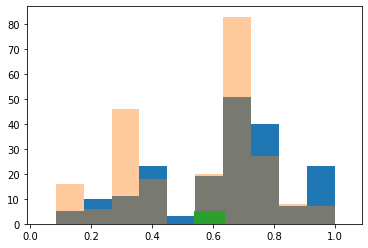

In [19]:
plt.hist(model_frame[model_frame['class'] == 0]['cfb'])
plt.hist(model_frame[model_frame['class'] == 1]['cfb'], alpha = .4)
plt.hist(model_frame[model_frame['class'] == 2]['cfb'], alpha = 1)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([-0.038,  0.062,  0.162,  0.262,  0.362,  0.462,  0.562,  0.662,
         0.762,  0.862,  0.962]),
 <a list of 10 Patch objects>)

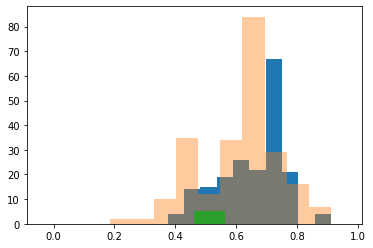

In [20]:
plt.hist(model_frame[model_frame['class'] == 0]['cbb'])
plt.hist(model_frame[model_frame['class'] == 1]['cbb'], alpha = .4)
plt.hist(model_frame[model_frame['class'] == 2]['cbb'], alpha = 1)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([0.073, 0.173, 0.273, 0.373, 0.473, 0.573, 0.673, 0.773, 0.873,
        0.973, 1.073]),
 <a list of 10 Patch objects>)

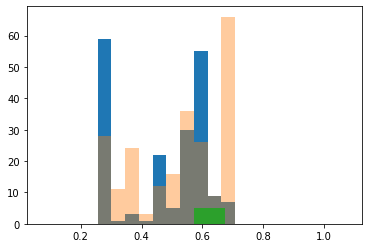

In [21]:
plt.hist(model_frame[model_frame['class'] == 0]['nba'])
plt.hist(model_frame[model_frame['class'] == 1]['nba'], alpha = .4)
plt.hist(model_frame[model_frame['class'] == 2]['nba'], alpha = 1)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([0.031, 0.131, 0.231, 0.331, 0.431, 0.531, 0.631, 0.731, 0.831,
        0.931, 1.031]),
 <a list of 10 Patch objects>)

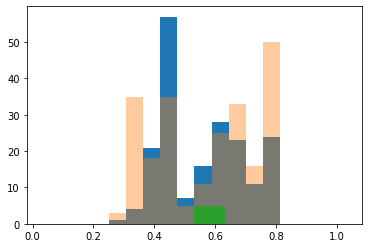

In [22]:
plt.hist(model_frame[model_frame['class'] == 0]['nfl'])
plt.hist(model_frame[model_frame['class'] == 1]['nfl'], alpha = .4)
plt.hist(model_frame[model_frame['class'] == 2]['nfl'], alpha = 1)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3]),
 <a list of 10 Patch objects>)

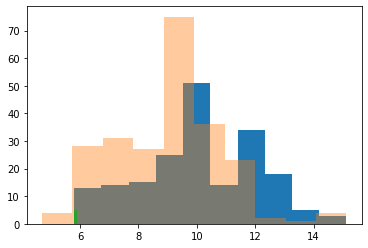

In [23]:
plt.hist(model_frame[model_frame['class'] == 0]['poverty'])
plt.hist(model_frame[model_frame['class'] == 1]['poverty'], alpha = .4)
plt.hist(model_frame[model_frame['class'] == 2]['poverty'], alpha = 1)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([35.8625, 35.9625, 36.0625, 36.1625, 36.2625, 36.3625, 36.4625,
        36.5625, 36.6625, 36.7625, 36.8625]),
 <a list of 10 Patch objects>)

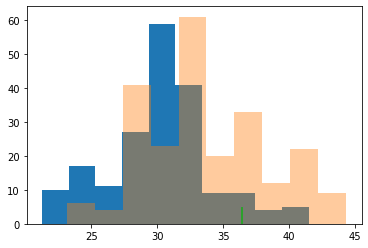

In [24]:
plt.hist(model_frame[model_frame['class'] == 0]['bachelors'])
plt.hist(model_frame[model_frame['class'] == 1]['bachelors'], alpha = .4)
plt.hist(model_frame[model_frame['class'] == 2]['bachelors'], alpha = 1)

In [25]:
model_frame_to_try = model_frame.drop(['state_po','state_district'], axis=1)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(model_frame_to_try.drop(['class'], axis=1), model_frame_to_try['class'], test_size=0.2, random_state=42)

In [61]:
neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [62]:
preds = neigh.predict(X_train)
neigh.score(X_train, y_train)
neigh.score(X_test, y_test)

0.5930232558139535

In [59]:
X_train

,cfb,nfl,nba,cbb,poverty,bachelors,hs,2015_GDP,2016_GDP,2017_GDP,difference,state_code
28349,0.6360,0.813,0.707,0.6360,9.303774,33.383019,83.313208,62347,63785,66262,-1.3,3
28635,0.3330,0.750,0.555,0.4370,8.700000,34.672222,89.422222,57875,58250,58942,-1.5,11
28915,0.6150,0.813,0.268,0.7600,9.162500,29.450000,90.425000,45572,45259,45541,-1.4,21
28420,0.6360,0.813,0.707,0.6360,9.303774,33.383019,83.313208,62347,63785,66262,-1.3,3
28466,0.0830,0.688,0.671,0.4375,7.080000,39.560000,90.940000,67710,67845,68184,-1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
28340,0.6360,0.813,0.707,0.6360,9.303774,33.383019,83.313208,62347,63785,66262,-1.3,3
28502,0.7690,0.438,0.537,0.6170,9.840741,30.314815,88.437037,41491,42013,42719,-1.2,6
29075,0.2700,0.313,0.354,0.6900,10.129630,36.985185,87.144444,69790,70752,72429,-0.8,29
29409,0.4166,0.563,0.268,0.7420,11.600000,27.444444,87.788889,45759,46355,46780,-1.2,36


In [88]:
X_train = X_train[['cfb','nfl','nba','cbb']]
X_test = X_test[['cfb','nfl','nba','cbb']]

random_forest_model = RandomForestClassifier(max_features = int(np.sqrt(X_train.shape[1])), max_depth=5, n_estimators = 55)
random_forest_model.fit(X_train, y_train)

random_forest_train_predictions = random_forest_model.predict(X_train)
random_forest_test_predictions = random_forest_model.predict(X_test)

random_forest_train_score = accuracy_score(y_train, random_forest_train_predictions)
random_forest_test_score = accuracy_score(y_test, random_forest_test_predictions)

print("Random Forest Train Score: " + str(random_forest_train_score))
print("Random Forest Test Score: " + str(random_forest_test_score))

Random Forest Train Score: 0.7426900584795322
Random Forest Test Score: 0.7093023255813954


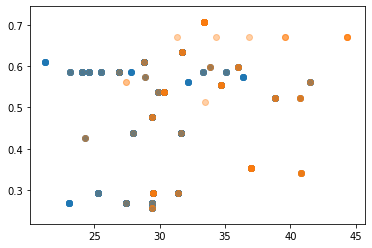

In [79]:
reps = model_frame[model_frame['class'] == 0]
dems = model_frame[model_frame['class'] == 1]
plt.scatter(reps['bachelors'], reps['nba'])
plt.scatter(dems['bachelors'], dems['nba'], alpha = .2)

In [86]:

def calc_meanstd(X_train, y_train, depths):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
        train_scores.append(score)
        cvmeans.append(score.mean())
        cvstds.append(np.std(score))
    # end of your code here
    return cvmeans, cvstds, train_scores

depths = np.linspace(1,20,num=20)
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

d5_tree = DecisionTreeClassifier(max_depth = 5)
d5_tree.fit(X_train, y_train)

d5_train_score = cross_val_score(estimator=d5_tree, X=X_train, y=y_train, cv=2)[0]
d5_test_score = cross_val_score(estimator=d5_tree, X=X_test, y=y_test, cv=2)[0]

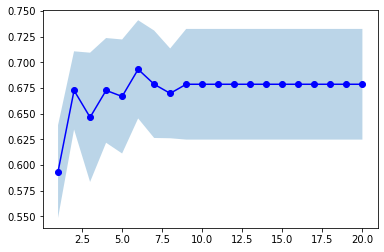

In [87]:
zipped_values = list(zip(cvmeans, cvstds))

upper_band = [a + b for a,b in zipped_values]

lower_band = [a - b for a,b in zipped_values]


plt.plot(depths, cvmeans, 'b-', marker = 'o', label = 'CVmeans')
plt.fill_between(depths, upper_band, lower_band, alpha = 0.3)

In [106]:
estimators = np.linspace(1,800,800)

ABC = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=10), learning_rate=.05, n_estimators = 800)

ABC.fit(X_train, y_train)

np.mean(list(ABC.staged_score(X_train, y_train)))

0.7485380116959064

In [107]:
np.mean(list(ABC.staged_score(X_test, y_test)))

0.7093023255813955